> **前言：** 之前讨论了（1步）时序差分方法（[ipynb链接](https://github.com/PiperLiu/Reinforcement-Learning-practice-zh/blob/master/practice/05-01-Temporal-Difference-Prediction.ipynb)）与蒙特卡洛方法（[ipynb链接](https://github.com/PiperLiu/Reinforcement-Learning-practice-zh/blob/master/practice/04-Monte-Carlo-Methods.ipynb)）。刚刚学习完 Sutton 的[《强化学习（第二版）》](http://rl.qiwihui.com/zh_CN/latest/chapter1/introduction.html)的第七章：n步自举法。它是时序差分方法与蒙特卡洛方法的折中，一般地，效果要好于二者。

*本次笔记不记录公式、算法框架，介绍思想。具体内容请见中文电子书：*

[第7章 n 步引导（Bootstrapping）方法](http://rl.qiwihui.com/zh_CN/latest/partI/chapter7/n_step_bootstrapping.html)

****

### n步自举法与时序差分方法、蒙特卡洛方法

![](images/06-01.png)

如上图：
- 时序差分方法中，下一状态的价值是“估计”出来的；
- 蒙特卡洛方法中，下一状态的价值是在整个幕都终止后，更加后续状态的折扣算出来的，是“已知”的；
- n步自举法有“部分估计”、“部分已知”的特性。但是，所有n步方法都要在更新之前延迟至n个时刻步长。

### 同轨策略下的控制：为什么n步比1步收敛得更快

![](images/06-02.png)

如上图，取自 Sutton 的书，只有G点有收益，状态到达G点后：
- 在1步控制中（即之前所谓的“时序差分学习”），到达G的前1步的“状态-动作”价值得到了增强；
- 在10步控制中，到达G的前的第10步就可以“感受”到价值的增强。

### 离轨策略下的n步学习：共4种

![](images/06-03.png)

在[蒙特卡洛方法](https://blog.csdn.net/weixin_42815609/article/details/104025586)中我讨论过“重要度采样率”，用于离轨策略下的学习（包括估值与控制）；在[时序差分控制](https://blog.csdn.net/weixin_42815609/article/details/104069627)的“期望Sarsa”中，采用后续状态的动作期望，对节点进行估值。**这两个思想在离轨策略下的n步学习中得以混合、应用。**

上图取自 Sutton 的书，从左到右的解释见下表：

|名称|介绍|
|---|---|
|可推广为带控制变量的每次决策型方法|基于后续n步状态的采样率对收益进行学习|
|不使用重要度采样：n步树回溯算法|基于后续n步状态的“状态-动作”-收益期望进行学习|
|n步期望Sarsa|基于后续第n步状态的“状态-动作”-收益期望进行学习，其他进行重要度采样*|
|n步Q(σ)|对后续n步交叉采取重要度采样率与期望进行学习|

[*] n步期望Sarsa 与 n步Sarsa略有不同：
- 在期望Sarsa中，采样率取$\rho_{t+1:t+n-1}$而非Sarsa的$\rho_{t+1:t+n}$；
- 因为在期望Sarsa方法中，最有一个状态考虑所有可能的动作，实际采取哪个动作不重要，无需修正。

### 代码：n步时序差分预测

使用例子 6.2 ，如下图。

![](images/06-04.png)

n步时序差分预测算法框图如下。

![](images/06-05.png)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:14<00:00,  4.81s/it]


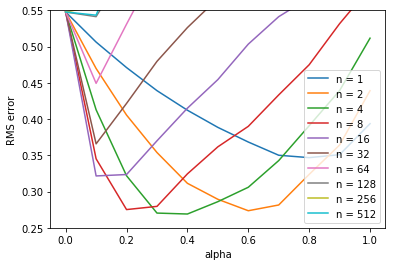

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

# all states
N_STATES = 19

# discount
GAMMA = 1

# all states but terminal states
STATES = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state value from bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0

# n-steps TD method
# @value: values for each state, will be updated
# @n: # of steps
# @alpha: # step size
def temporal_difference(value, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            if np.random.binomial(1, 0.5) == 1:
                next_state = state + 1
            else:
                next_state = state - 1

            if next_state == 0:
                reward = -1
            elif next_state == 20:
                reward = 1
            else:
                reward = 0

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += pow(GAMMA, t - update_time - 1) * rewards[t]
            # add state value to the return
            """
            这里的 if update_time + n <= T
            表示如果后续第 n 步状态没有终止，那么对于n步状态之后的状态（ n+1, ... , 终止）采用估值
            即： value[state[(update_time + n)]]
            否则，无需估值。
            """
            if update_time + n <= T:
                returns += pow(GAMMA, n) * value[states[(update_time + n)]]
            state_to_update = states[update_time]
            # update the state value
            if not state_to_update in END_STATES:
                value[state_to_update] += alpha * (returns - value[state_to_update])
        if update_time == T - 1:
            break
        state = next_state

# Figure 7.2, it will take quite a while
def figure7_2():
    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in tqdm(range(0, runs)):
        for step_ind, step in enumerate(steps):
            for alpha_ind, alpha in enumerate(alphas):
                # print('run:', run, 'step:', step, 'alpha:', alpha)
                value = np.zeros(N_STATES + 2)
                for ep in range(0, episodes):
                    temporal_difference(value, step, alpha)
                    # calculate the RMS error
                    errors[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(value - TRUE_VALUE, 2)) / N_STATES)
    # take average
    errors /= episodes * runs

    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = %d' % (steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.25, 0.55])
    plt.legend()

    plt.show()

figure7_2()

来自：[Zhang's GitHub](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/tree/master/chapter07)

运行结果：

我对代码进行了1处标注。

### 其他：数学性

本章公式较多，值得一提的是，n步时序差分方法有坚实的数学基础，引用书上的话：在最坏的情况下，采用它的期望值作为对$v_k$的估计可以保证比$V_{k+n-1}$更好；即n步回报的期望的最坏误差能够保证不大于$V_{t+n-1}$的最坏误差的$\gamma^n$倍（$\gamma \le 1$）。

$$\max _{s}\left|\mathbb{E}_{\pi}\left[G_{t: t+n} | S_{t}=s\right]-v_{\pi}(s)\right| \leq \gamma^{n} \max _{s}\left|V_{t+n-1}(s)-v_{\pi}(s)\right|$$

但 n 并非越大越好，从代码产生的例子中我们可以看出。

此外，更新公式间的递推转换，不予过分关注。

另外提一点： Sutton 在第一版中认为“n步算法在实际中不可行”，而见过Cichosz（1995），van Seijen（2016）的研究后，认为其为很实用的算法。